In [1]:
#!/usr/bin/env python

# data tools
import os, cv2, glob, argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# sklearn tools
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# tf tools
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (Conv2D,
                                     MaxPool2D,
                                     MaxPooling2D, 
                                     Activation, 
                                     Flatten,
                                     Dropout,
                                     Dense)
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)

# Define functions

In [107]:
height = 224
width = 224
epochs = 10
base_learning_rate = 0.001

# Define model
base_model = tf.keras.applications.MobileNetV2(input_shape = (224, 224, 3), include_top = False, weights = "imagenet")

# Refrain from training the pretrained weights
base_model.trainable = False

# Add layers to the pre-trained model
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(2, activation="softmax")])

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(lr = base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy'])

def read_from_folders(folders):
    """
    Function which reads images from a list of folders, as well as generates a label, based on the folder names. 
    Returns a data frame with all the information.
    """
    arrays = []
    labels = []
    
    for folder in folders:
        
        folderpath = os.path.join("data", folder)
        
        print(f"[INFO] Loading images from: \"{folderpath}\" ...") # Info for terminal
        
        for file in glob.glob(os.path.join(folderpath, "*.jpg")):
            arrays.append(cv2.imread(file))
            labels.append(f"{os.path.split(folderpath)[1]}")
    
    # Create dataframe from labels and arrays
    df = pd.DataFrame.from_dict({"X" : arrays, "y" : labels})
    
    return df

# Define function for resizing and making into array
def get_resized_arrays(arrays, width, height):
    """
    Function which resizes arrays to input dimensions - also scales arrays to be between 0 and 1
    """
    # Info for terminal use
    print("[INFO] Resizing images ...")
    
    # If pd.series, convert to list
    if type(arrays) == "pandas.core.series.Series":
        arrays = list(arrays)
    
    # Empty list for appending to
    arrays_resized = []
    
    # For every array in the list of arrays
    for array in arrays:
        # Resize array
        resized = cv2.resize(array, (width, height), interpolation = cv2.INTER_AREA)
        
        # Convert to array and values between 0 and 1 to allow to be used in CNN (using list comprehension)
        resized = np.asarray(resized/255.).astype("float32")

        # Append to list
        arrays_resized.append(resized)

    # Return
    return arrays_resized

def get_formatted(X, y):
    """
    Function that formats arrays and labels to be usable in the CNN.
    """
    # Format X
    X = np.array(X).reshape(len(X), width, height, 3)
    
    # Format y
    lb, enc = LabelEncoder(), OneHotEncoder()
    y = lb.fit_transform(y).reshape(-1,1)
    y = enc.fit_transform(y).toarray()
    
    return X, y

def plot_history(H, epochs):
    """
    Function which plots accuracy and loss over epochs.
    """
    # Make a list of epochs
    epochs_range = range(epochs)
    
    # Create a plot showing accuracies
    plt.figure(figsize = (15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, H.history['accuracy'], label = 'Training accuracy')
    plt.plot(epochs_range, H.history['val_accuracy'], label = 'Validation accuracy')
    plt.legend(loc = 'lower right')
    plt.title('Training and Validation Accuracy')

    # Create a plot showing loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, H.history['loss'], label = 'Training loss')
    plt.plot(epochs_range, H.history['val_loss'], label = 'Validation loss')
    plt.legend(loc = 'upper right')
    plt.title('Training and Validation Loss')
    
    #Save plot
    plt.savefig(os.path.join("out", 'training_history.png'), format = 'png', dpi = 100)
    plt.show()

def get_classif_report(X_test, y_test, outname):
    # Make predictions
    predictions = model.predict(X_test, batch_size = 32)
    
    # Create classification report
    classif_report = pd.DataFrame(classification_report(y_test.argmax(axis = 1),
                                predictions.argmax(axis = 1),
                                target_names = label_names, output_dict = True))
    
    # Create outpath if it does not already exist
    if not os.path.exists("out"):
        os.makedirs("out")
    
    # Print and save classification report
    print(classif_report)
    
    # Save classification report
    classif_report_outpath = os.path.join("out", f'{outname}')
    classif_report.to_csv(classif_report_outpath, sep = ',', index = True)
    print(f"A classification report has been saved succesfully: \"{classif_report_outpath}\"")

In [108]:
# Load data
folders = os.listdir("data")
df = read_from_folders(folders)
df["X"] = get_resized_arrays(df["X"], 224, 224)

[INFO] Loading images from: "data/content_monet_style_cezanne" ...
[INFO] Loading images from: "data/content_monet_style_monet" ...
[INFO] Loading images from: "data/content_cezanne_style_monet" ...
[INFO] Loading images from: "data/content_cezanne_style_cezanne" ...
[INFO] Resizing images ...


# Train Monet/Cezanne classifier

In [109]:
# Create dataframe with subset
df_orig = df.loc[(df['y'] == "content_monet_style_monet") | (df['y'] == "content_cezanne_style_cezanne")]
df_orig = df_orig.replace({'y' : { 'content_monet_style_monet' : "monet", 'content_cezanne_style_cezanne' : "cezanne"}})

In [110]:
# Define X and y
X = list(df_orig["X"])
y = list(df_orig["y"])

In [111]:
#Get labelnames
label_names = set(y)

In [112]:
# Format to match expected input for CNN
X, y = get_formatted(X, y)

In [113]:
# Make a test-train split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state = 9, # for replication purposes
                                                    train_size = .8)

In [114]:
# Fit the model to the data
history = model.fit(X_train, y_train, 
              validation_data = (X_test, y_test), 
              batch_size = 32,
              epochs = epochs)

Epoch 1/10
25/25 [==============================] - 24s 851ms/step - loss: 0.7820 - accuracy: 0.4840 - val_loss: 0.3886 - val_accuracy: 0.8593
Epoch 2/10
25/25 [==============================] - 20s 819ms/step - loss: 0.3897 - accuracy: 0.8651 - val_loss: 0.2696 - val_accuracy: 0.9196
Epoch 3/10
25/25 [==============================] - 19s 767ms/step - loss: 0.2938 - accuracy: 0.9040 - val_loss: 0.2310 - val_accuracy: 0.9246
Epoch 4/10
25/25 [==============================] - 20s 812ms/step - loss: 0.2469 - accuracy: 0.9059 - val_loss: 0.2058 - val_accuracy: 0.9447
Epoch 5/10
25/25 [==============================] - 20s 810ms/step - loss: 0.2020 - accuracy: 0.9381 - val_loss: 0.2044 - val_accuracy: 0.9397
Epoch 6/10
25/25 [==============================] - 21s 843ms/step - loss: 0.1831 - accuracy: 0.9375 - val_loss: 0.1831 - val_accuracy: 0.9397
Epoch 7/10
25/25 [==============================] - 20s 817ms/step - loss: 0.1972 - accuracy: 0.9302 - val_loss: 0.1774 - val_accuracy: 0.9397

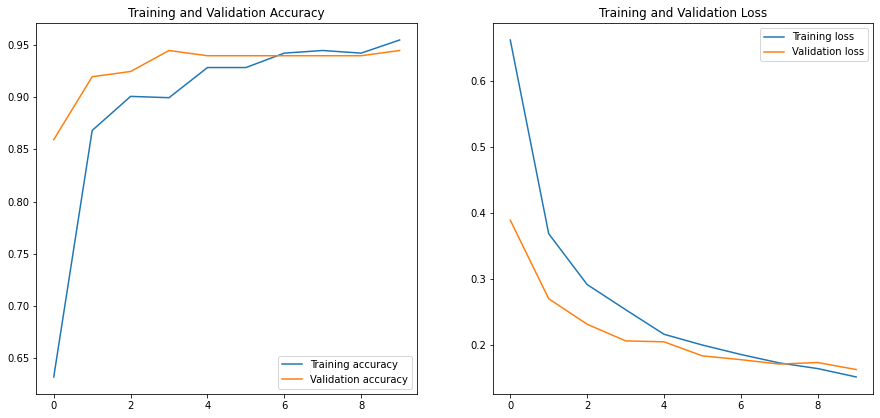

In [115]:
plot_history(history, epochs)

# Test Monet/Cezanne classifier

In [116]:
get_classif_report(X_test, y_test, "classification_report_generated.csv")

                monet    cezanne  accuracy   macro avg  weighted avg
precision    0.924528   0.967742  0.944724    0.946135      0.945809
recall       0.970297   0.918367  0.944724    0.944332      0.944724
f1-score     0.946860   0.942408  0.944724    0.944634      0.944668
support    101.000000  98.000000  0.944724  199.000000    199.000000
A classification report has been saved succesfully: "out/classification_report_generated.csv"


# Testing classifier on generated data

In [117]:
df_stylized = df.loc[(df['y'] == "content_monet_style_cezanne") | (df['y'] == "content_cezanne_style_monet")]
df_stylized = df_stylized.replace({'y' : { 'content_monet_style_cezanne' : "monet", 'content_cezanne_style_monet' : "cezanne"}})

In [118]:
X = list(df_stylized["X"])
y = list(df_stylized["y"])

In [119]:
# Format to match expected input for CNN
X_test, y_test = get_formatted(X, y)

In [120]:
# Get and save classification report
get_classif_report(X_test, y_test, "classification_report_generated.csv")

                monet     cezanne  accuracy   macro avg  weighted avg
precision    0.206089    0.278660  0.247485    0.242374      0.242374
recall       0.177062    0.317907  0.247485    0.247485      0.247485
f1-score     0.190476    0.296992  0.247485    0.243734      0.243734
support    497.000000  497.000000  0.247485  994.000000    994.000000
A classification report has been saved succesfully: "out/classification_report_generated.csv"


In [121]:
# Seems less reliant on content, and more on style ... ?